# Preparation

Start by unzipping the file

In [ ]:
#!unzip "Dataset.zip"

In [ ]:
#!pip install --upgrade tensorflow keras

In [ ]:
#!pip install --upgrade tensorflow

# Simple Version (Base Model) Working on More Complex One Currently

In [11]:
#cell1
import matplotlib.pyplot as plt
import os
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from keras.layers import Flatten, Dense
from keras.models import Model

#Most of the Images are size 474x()
IMAGE_SIZE=(474, 474) 
train_path=".../Dataset"
folders=sorted(os.listdir(train_path), reverse=False)
#Create VGG model with pre-trained weights
vgg=VGG16(input_shape=(*IMAGE_SIZE, 3),weights='imagenet', include_top=False)
#Freeze the pre-trained layers
for layer in vgg.layers:
    layer.trainable=False
#Flatten the output layer to 1 dimension
x=Flatten()(vgg.output)
#Add a dense layer with softmax activation for the number of classes
prediction=Dense(len(folders),activation='softmax')(x)
model=Model(inputs=vgg.input, outputs=prediction)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

#split train test
train_datagen=ImageDataGenerator(rescale=1./255, validation_split=0.1)

#Create data generators for training and testing
train_set=train_datagen.flow_from_directory(train_path,target_size=IMAGE_SIZE,batch_size=32,class_mode='categorical',subset='training',shuffle=True,seed=42)
test_set=train_datagen.flow_from_directory(train_path,target_size=IMAGE_SIZE,batch_size=32,class_mode='categorical',subset='validation',shuffle=True,seed=42)

#Training portion
#use 10 epochs typically
r=model.fit(train_set,validation_data=test_set,epochs=3,steps_per_epoch=len(train_set),validation_steps=len(test_set))


#save it to test for later
model.save('base_face.h5')

Found 1620 images belonging to 17 classes.
Found 180 images belonging to 17 classes.
Epoch 1/3
51/51 [==============================] - 208s 4s/step - loss: 9.5342 - accuracy: 0.1877 - val_loss: 2.2887 - val_accuracy: 0.4278
Epoch 2/3
51/51 [==============================] - 206s 4s/step - loss: 0.5196 - accuracy: 0.8537 - val_loss: 1.3116 - val_accuracy: 0.6222
Epoch 3/3
51/51 [==============================] - 206s 4s/step - loss: 0.0791 - accuracy: 0.9796 - val_loss: 0.8672 - val_accuracy: 0.7278


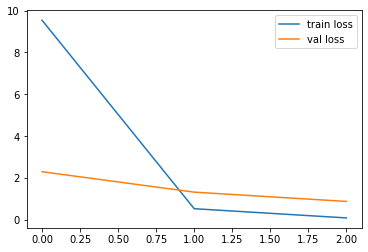

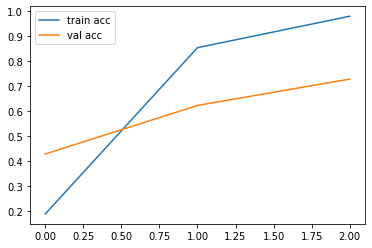

<Figure size 432x288 with 0 Axes>

In [12]:
#cell2
#loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss.png')

#accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc.png')

# testing the model

In [13]:
#cell3
import matplotlib.pyplot as plt
import os
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from keras.layers import Flatten, Dense
from keras.models import Model
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.preprocessing import image
import numpy as np

In [14]:
#cell4
train_path=".../Dataset"
folders=sorted(os.listdir(train_path), reverse=False)

In [16]:
#cell5
import cv2
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.preprocessing import image
import numpy as np

#Load the trained model ssaved earlier
model=load_model('.../base_face.h5')

#Load OpenCV face detection model
prototxt_path='.../deploy.prototxt'
caffemodel_path='.../res10_300x300_ssd_iter_140000_fp16.caffemodel'
net=cv2.dnn.readNetFromCaffe(prototxt_path, caffemodel_path)

#Instead of rescaling the image in the data generator, rescale it in the preprocessing function
def preprocess_image(img_path,target_size=IMAGE_SIZE):
    img=image.load_img(img_path, target_size=target_size)
    img_array=image.img_to_array(img)
    img_array=img_array/255.0  #Normalize the image
    img_array=np.expand_dims(img_array, axis=0)
    return img_array

def detect_faces_and_predict(image_path):
    #Read the image
    img=cv2.imread(image_path)
    h, w =img.shape[:2]
    #Detection from OpenCV
    blob=cv2.dnn.blobFromImage(cv2.resize(img, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
    net.setInput(blob)
    faces=net.forward()

    #Iterate over detected faces
    for i in range(faces.shape[2]):
        confidence=faces[0, 0, i, 2]
        #Filter out weak detections and do not use those
        if confidence>0.5:
            box=faces[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY)=box.astype("int")
            #Extract the face ROI without normalizing
            face_roi=img[startY:endY, startX:endX]
            face_roi=cv2.resize(face_roi, IMAGE_SIZE)
            #Preprocess the image for prediction
            face_array=preprocess_image(image_path, target_size=IMAGE_SIZE)
            #Make predictions on the face
            predictions=model.predict(face_array)
            #Print predicted probabilities for each class
            for j, prob in enumerate(predictions[0]):
                print(f"Probability for {folders[j]}: {prob}")
            #Get the predicted class index
            predicted_class_index=np.argmax(predictions)
            #Map the class index to the celebrity name
            celebrity_name=folders[predicted_class_index]
            #Draw bounding box and label on the image
            cv2.rectangle(img, (startX, startY),(endX, endY), (0, 255, 0), 2)
            cv2.putText(img, f"{celebrity_name}: {predictions[0][predicted_class_index]:.3f}", (startX, startY - 10),
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)


    #Display the image with bounding boxes and labels
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  #Convert BGR to RGB so image is properly colored
    plt.show()

    #Return predictions for later use
    return predictions


Probability for Angelina Jolie: 0.00019719440024346113
Probability for Brad Pitt: 3.959578862122726e-06
Probability for Denzel Washington: 1.6172621144505683e-06
Probability for Hugh Jackman: 2.021091738413361e-08
Probability for Jennifer Lawrence: 9.721630931380787e-07
Probability for Johnny Depp: 7.330759217438754e-07
Probability for Kate Winslet: 7.80132359068375e-06
Probability for Leonardo DiCaprio: 1.3479476423938763e-09
Probability for Megan Fox: 0.9985172152519226
Probability for Natalie Portman: 0.0011807181872427464
Probability for Nicole Kidman: 7.3308883656864055e-06
Probability for Robert Downey Jr: 5.725042129256508e-08
Probability for Sandra Bullock: 6.552570994244888e-05
Probability for Scarlett Johansson: 1.1813093806267716e-05
Probability for Tom Cruise: 1.4400862937691272e-06
Probability for Tom Hanks: 2.4802855023153825e-06
Probability for Will Smith: 1.0896496860368643e-06


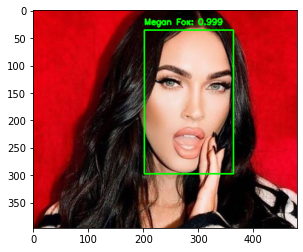

Predicted Celebrity: Megan Fox index number: 8


In [19]:
#cell6
test_image_path='.../megan_fox_test.png'
predictions_1=detect_faces_and_predict(test_image_path)
predicted_class_index=np.argmax(predictions_1)
celebrity_name=folders[predicted_class_index]
print("Predicted Celebrity:", celebrity_name, "index number:", predicted_class_index)

# Improvements

This is a very rough implementation of the model. Should probably incorporate cropping using bounding box before training using the max confidence face detected as we only want the subjects face and want to eliminate as much noise from the background in training as possible, which cropping can do. Should also consider what augmentations to add for optimal training. Can also consider using a lower learning rate so model can better learn nuiances between faces. Need to test on more images.